In [2]:
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
from math import e
import statistics as st
import cmath
import scipy
import scipy.stats as ss
import random
import seaborn as sns
import pandas as pd
import emcee
import corner
import h5py
import numpy.ma as ma

In [28]:
import os
print(os.cpu_count())

32


## RLC Avg

In [3]:
avg = h5py.File('/home/saurabhs/Documents/amarnath/hdatasets/2025-04-13_053004.pyavg','r')

In [4]:
#Frequencies
avg['pyavg'].keys()
sfreq = avg.attrs['sfreq']
print(avg.attrs.keys())
freq=np.arange(0,8193,1)*sfreq*1e3
#print(freq)
ind_freq=np.logical_and((freq>=40),(freq<=110))
print(freq[ind_freq])
req_freq=freq[ind_freq]*1e6

<KeysViewHDF5 ['sfreq']>
[ 40.00854492  40.0390625   40.06958008 ... 109.92431641 109.95483398
 109.98535156]


In [5]:
SPCD_avg=avg['SPCD'][0, ind_freq].real
SPCF_avg=avg['SPCF'][0, ind_freq].real
mask_avg=avg['mask'][0, ind_freq].real
print(len(mask_avg))

2294


/home/saurabhs/anaconda3/envs/saras/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


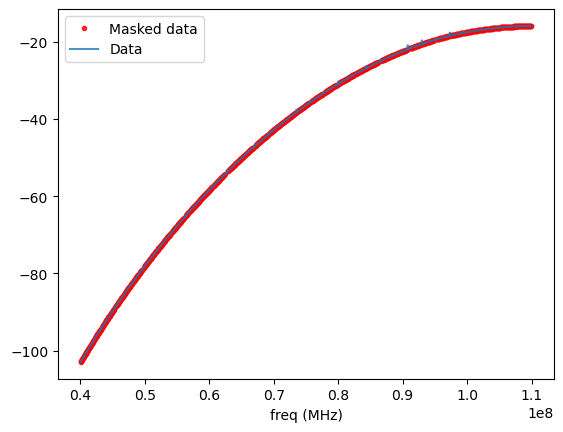

In [23]:
TMeas_exp_avg=ma.masked_array(SPCD_avg,np.logical_not(mask_avg))  ##Masking
plt.plot(req_freq,TMeas_exp_avg,'r.', label='Masked data', alpha=0.8)
plt.plot(req_freq,SPCD_avg, alpha=0.8, label='Data')
plt.xlabel('freq (MHz)')
plt.legend()
plt.show()

In [24]:
def Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    c=3*1e8
    l=l
    N=7
    global req_freq #[d[i][0] for i in range(len(d))]
    for i in range(len(req_freq)):
        gamma_A=p0*1e-48*req_freq[i]**(N - 1) + p1*1e-39*req_freq[i]**(N - 2) + p2*1e-31*req_freq[i]**(N - 3) + p3*1e-23*req_freq[i]**(N - 4) + p4*1e-15*req_freq[i]**(N - 5) + p5*1e-08*req_freq[i]**(N - 6) + p6*1e-01
        
        phi= (4*math.pi*(req_freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*(1-(gamma_A**2))*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return Tmeas

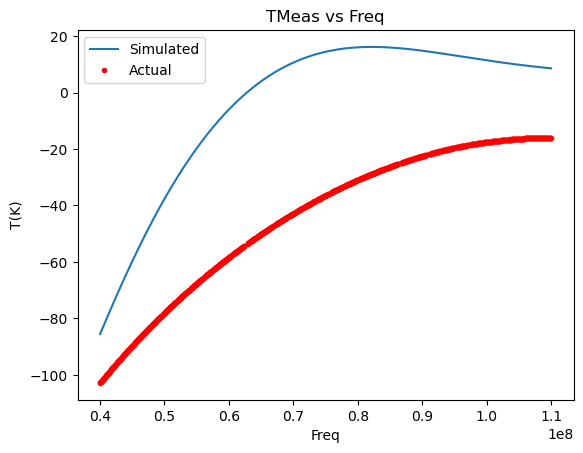

In [25]:
T=Compute_Tmeas_RLC(300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07, 4.73, 70, 0.3, 0.1, 0.15)

plt.plot(req_freq,T, label="Simulated")
plt.plot(req_freq,TMeas_exp_avg,'r.',label="Actual")
plt.legend()
plt.xlabel("Freq")
plt.ylabel("T(K)")
plt.title("TMeas vs Freq")
plt.show()

## Open

In [10]:
data = map(lambda x: [ x[0], x[1], x[2] ],
        np.loadtxt("/home/saurabhs/Documents/gopi/Saras_New/saras3_S11_200mm_above_water.s1p", skiprows=5))

d=list(data) #List of the format [Frequency, Magnitude, Phase (in degrees)]
c=3*10**8  # speed of light (m/s)
freq=[d[i][0] for i in range(len(d)-1)] #frequency
df=pd.read_csv('/home/saurabhs/Documents/gopi/Saras_New/S11_for_freq.csv')
rlc = df[df.columns[1]].values.tolist()

In [11]:
def Compute_Tmeas_(PA, gamma_A, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    l=l
    freq= [d[i][0] for i in range(len(d)-1)]
    for i in range(len(freq)):
        
        phi= (4*math.pi*(freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return(Tmeas)

## MCMC for Open

In [12]:
########## Define the log-likelihood function
def log_likelihood_o(params,**kwargs):
    ip_params=kwargs["ip_params"]
    seed=kwargs["seed"]
    s = kwargs["s"]  # Uncertainty
    
    PA, gamma_A, PN, gamma_N, f, l = params
    
    # Define the Expected TA values
    
    np.random.seed(seed)
    TA_exp = Compute_Tmeas_(*ip_params) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    # Compute model TA
    TA_model = Compute_Tmeas_(PA, gamma_A, PN, gamma_N, f,  l)
    TA_model=np.array(TA_model)

    # Compute chi-squared with weights
    
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 #- np.log(math.sqrt(2*np.pi)*s)  # Likelihood function

########## Define the log-prior function
def log_prior_o(params):
    
    PA, gamma_A, PN, gamma_N, f, l = params

    if ((0 <= gamma_A <= 1) and (0 <= gamma_N <= 1) and (0<=PA<=3) and (50<=PN<=150) and (0.05<=f<=0.5) and (0.05<l<2)) : 
            return 0.0  # Reject sample
    return -np.inf # Uniform prior

######### Define the full log-probability function

def log_probability_o(params,**kwargs):
    lp = log_prior_o(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_o(params,**kwargs)

########### MCMC

def evolve_MCMC_o(**kwargs):# Define parameter names
    parameter_names = ["PA", "gamma_A", "PN", "gamma_N", "f","l"]

    # Number of walkers and steps
    ndim = 6  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    # Initialize walkers around a random point in parameter space
    initial_value= np.array(kwargs["initial_value"])
    
    ## Starting positions for the walkers
    seed=kwargs["seed"]
    np.random.seed(seed+1)
    
    pos= initial_value[None,:] + initial_value*1e-2*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*

    #Make sure all the positions are positive
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)]) 

    def wrap_log_probability_o(params):
        return log_probability_o(params,**kwargs)
        
    ############ Set up the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrap_log_probability_o, threads=10)
    print(sampler.acceptance_fraction) #Mean Acceptance Ration
    ############ Run MCMC
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples_o=sampler.get_chain()

    samples_o = sampler.get_chain(discard=500, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes_o = np.array([log_likelihood_o(p, **kwargs) for p in samples_o])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes_o)
    
    ########## Get the best-fit parameters
    best_fit_params_o = samples_o[max_likelihood_index].tolist()

    return full_samples_o,samples_o,best_fit_params_o

In [13]:
#evolve MCMC
ip_params=[0,1,70,0.3,0.1,0.15] #input parameters
nsteps=3000
initials=[0.007,0.97,70.7,0.29,0.1,0.13]
s=0.001
seed=6
kwargs={"s":s,"seed":seed, "nsteps":nsteps, "ip_params":ip_params, "initial_value":initials}
full_samples_o, samples_o, best_fit_params_o= evolve_MCMC_o(**kwargs)

/home/saurabhs/anaconda3/envs/saras/lib/python3.11/site-packages/emcee/ensemble.py:542: RuntimeWarning: invalid value encountered in divide
  return self.backend.accepted / float(self.backend.iteration)


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [11:45<00:00,  4.25it/s]


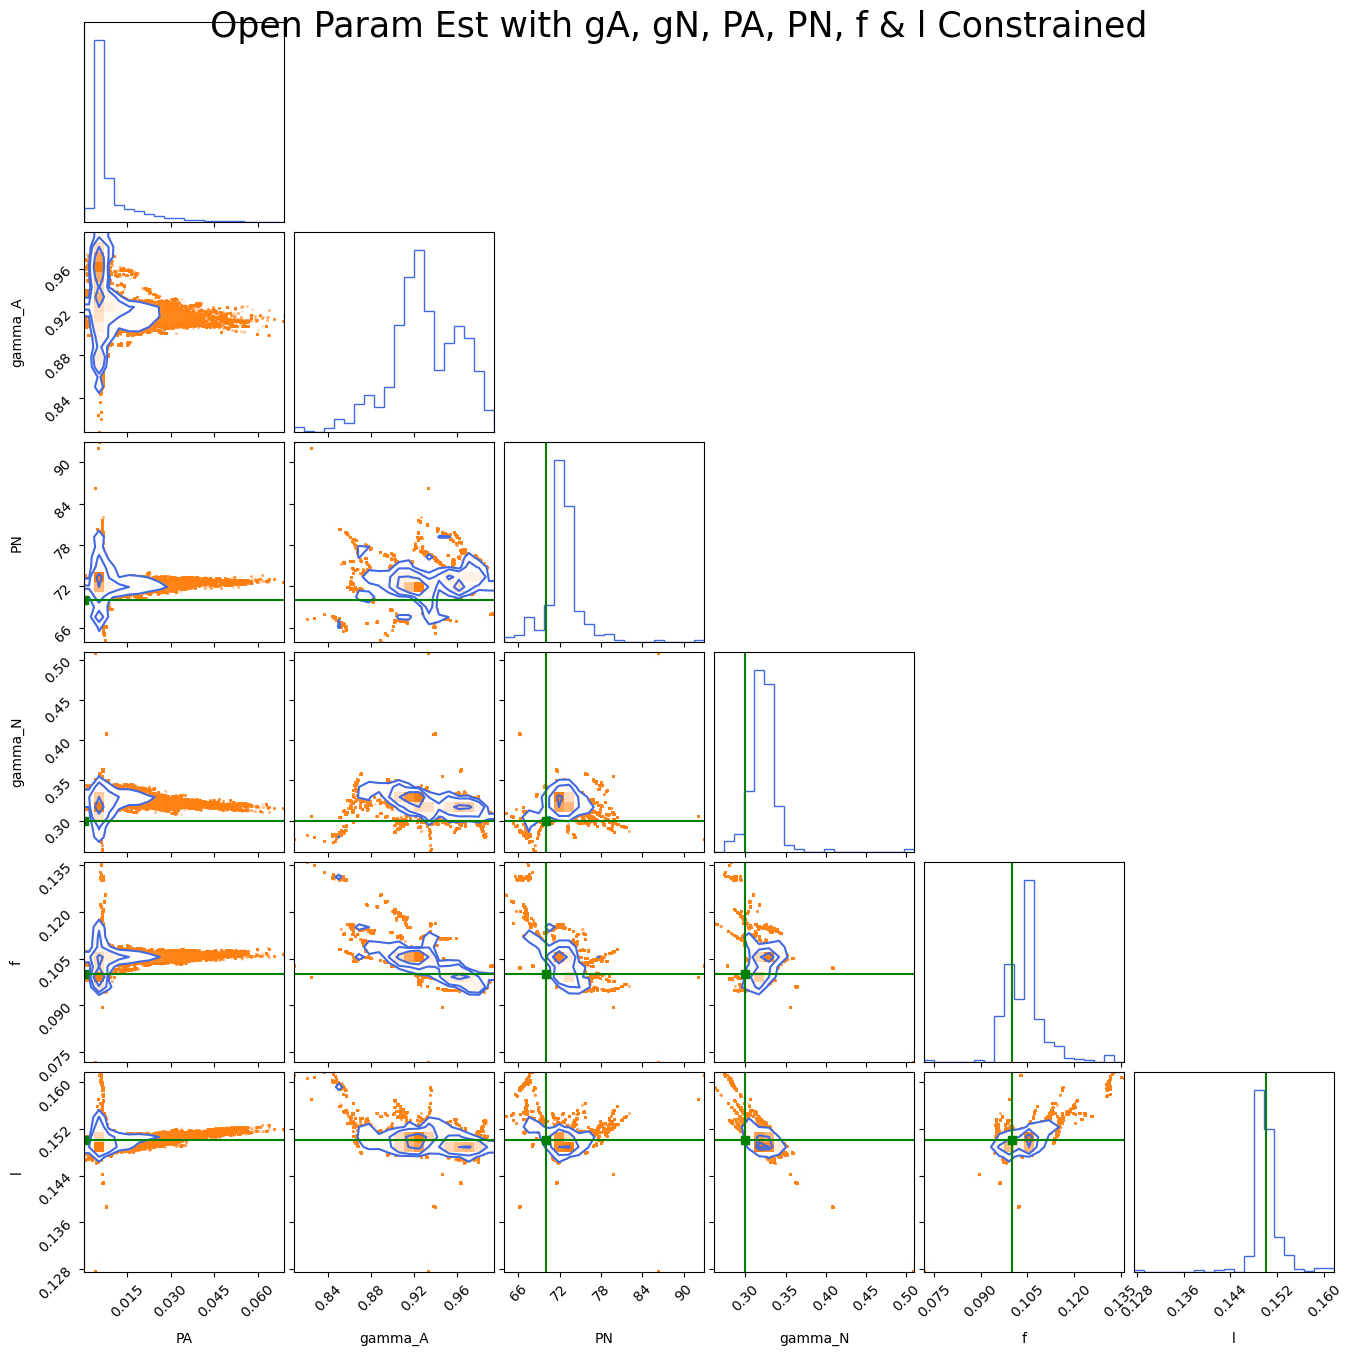

Best-fit parameters (Maximum Likelihood Estimate): [0.02067051374784898, 0.9287089069170731, 71.43706303809641, 0.3185361042112389, 0.10595717787819937, 0.15067380390226337]


In [14]:
parameter_names = ["PA", "gamma_A", "PN", "gamma_N", "f","l"]
#corner plot 
fig = corner.corner(samples_o, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Open Param Est with gA, gN, PA, PN, f & l Constrained", fontsize=25)
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/Untitled Folder/Open_All_15cm_1.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_o)

## MCMC for RLC real data

In [29]:
########## Define the log-likelihood function
def log_likelihood_full(params,**kwargs):

    # Compute TA expected
    seed=kwargs["seed"]
    #ip_params=kwargs["ip_params"]
    v=kwargs["v"]
    s=kwargs["s"]
    TA_exp=kwargs["TMeas_exp"]
    #PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = ip_params
    
    np.random.seed(seed)
    #TA_exp = Compute_Tmeas_(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) + np.random.normal(0,0.001,len(v))  # Expected TA values
    #TA_exp=np.array(TA_exp)
    
    # Compute model TA

    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    TA_model = Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l) 
    TA_model=np.array(TA_model)
    #print(len(TA_model))

    # Compute chi-squared
    chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 

    return -0.5*chi2 #- np.log(math.sqrt(2*np.pi)*s)

########## Define the log-prior function
def log_prior_full(params, **kwargs):

    
    v=kwargs["v"]
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l = params
    gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
    
    if (np.amin(gamma_A)>=0 and np.amax(gamma_A)<=1 and 0<=gamma_N<=1 and PA>0 and PN>0 and f>0 and l>0):
        return 0.0  # Accept sample
    
    return -np.inf # Reject prior
        
    
######### Define the full log-probability function
    
def log_probability_full(params, **kwargs):
    lp = log_prior_full(params,**kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_full(params,**kwargs)


########## MCMC for RLC Coeffs.
def evolve_MCMC_Full(**kwargs):
    
    # Define parameter names
    parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f", "l"]

    #args=args
    
    ## Number of walkers and steps
    
    ndim = 12  # Number of parameters
    nwalkers = 200  # Number of MCMC walkers
    nsteps = kwargs["nsteps"]  # Number of MCMC steps per walker
    
    ## Initialize walkers around a random point in parameter space
    
    initial_value=kwargs["initial_value"]

    ## Starting positions for the walkers (making sure that the initial positions satisfy the priors)
    
    pos_valid = []
    while len(pos_valid) < nwalkers:
        trial = initial_value + 1e-1 * np.random.randn(ndim)
        if np.isfinite(log_prior_full(trial, **kwargs)):
            pos_valid.append(trial)
    pos = np.array(pos_valid)
    #pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    
    
    ## for making sure only positive positional values
    """
    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    """ 
    
    def wrapped_log_prob_full(params):
        return log_probability_full(params, **kwargs)
    
    ## Set up the MCMC sampler
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, wrapped_log_prob_full, threads=15)
    
    ## Run MCMC
    
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ## Extract the samples
    
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ## Compute log-likelihoods for all samples
    
    log_likes = np.array([log_likelihood_full(p, **kwargs) for p in samples])
    
    ## Find the index of the maximum likelihood
    
    max_likelihood_index = np.argmax(log_likes)
    
    ## Get the best-fit parameters
    
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [ ]:
#evolve MCMC full with initials for system parameters from Open
#ip_params=[300, -6.33, 2.67, -4.56, 4.18, -2.19, 5.07, 4.73, 70, 0.3, 0.1, 0.15]
seed=42
PA, gA, PN, gN, f, l=best_fit_params_o
p0, p1, p2, p3, p4, p5, p6= -6.33, 2.67, -4.56, 4.18, -2.19, 5.07, 4.73
initials=[300,p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l]
nsteps=3000
TMeas_exp=TMeas_exp_avg
v=req_freq
s=SPCF_avg.real#0.01 #uncertainity
kwargs = {"s":s, "v":v, "seed":seed, "nsteps":nsteps,"initial_value":initials,"TMeas_exp":TMeas_exp} #"ip_params":ip_params}

full_samples_full, samples_full, best_fit_params_full= evolve_MCMC_Full(**kwargs)

Running MCMC...


/home/saurabhs/anaconda3/envs/saras/lib/python3.11/site-packages/emcee/ensemble.py:495: ComplexWarning: Casting complex values to real discards the imaginary part
  log_prob = np.array([float(l) for l in results])
 10%|███▉                                  | 306/3000 [26:06<3:51:20,  5.15s/it]

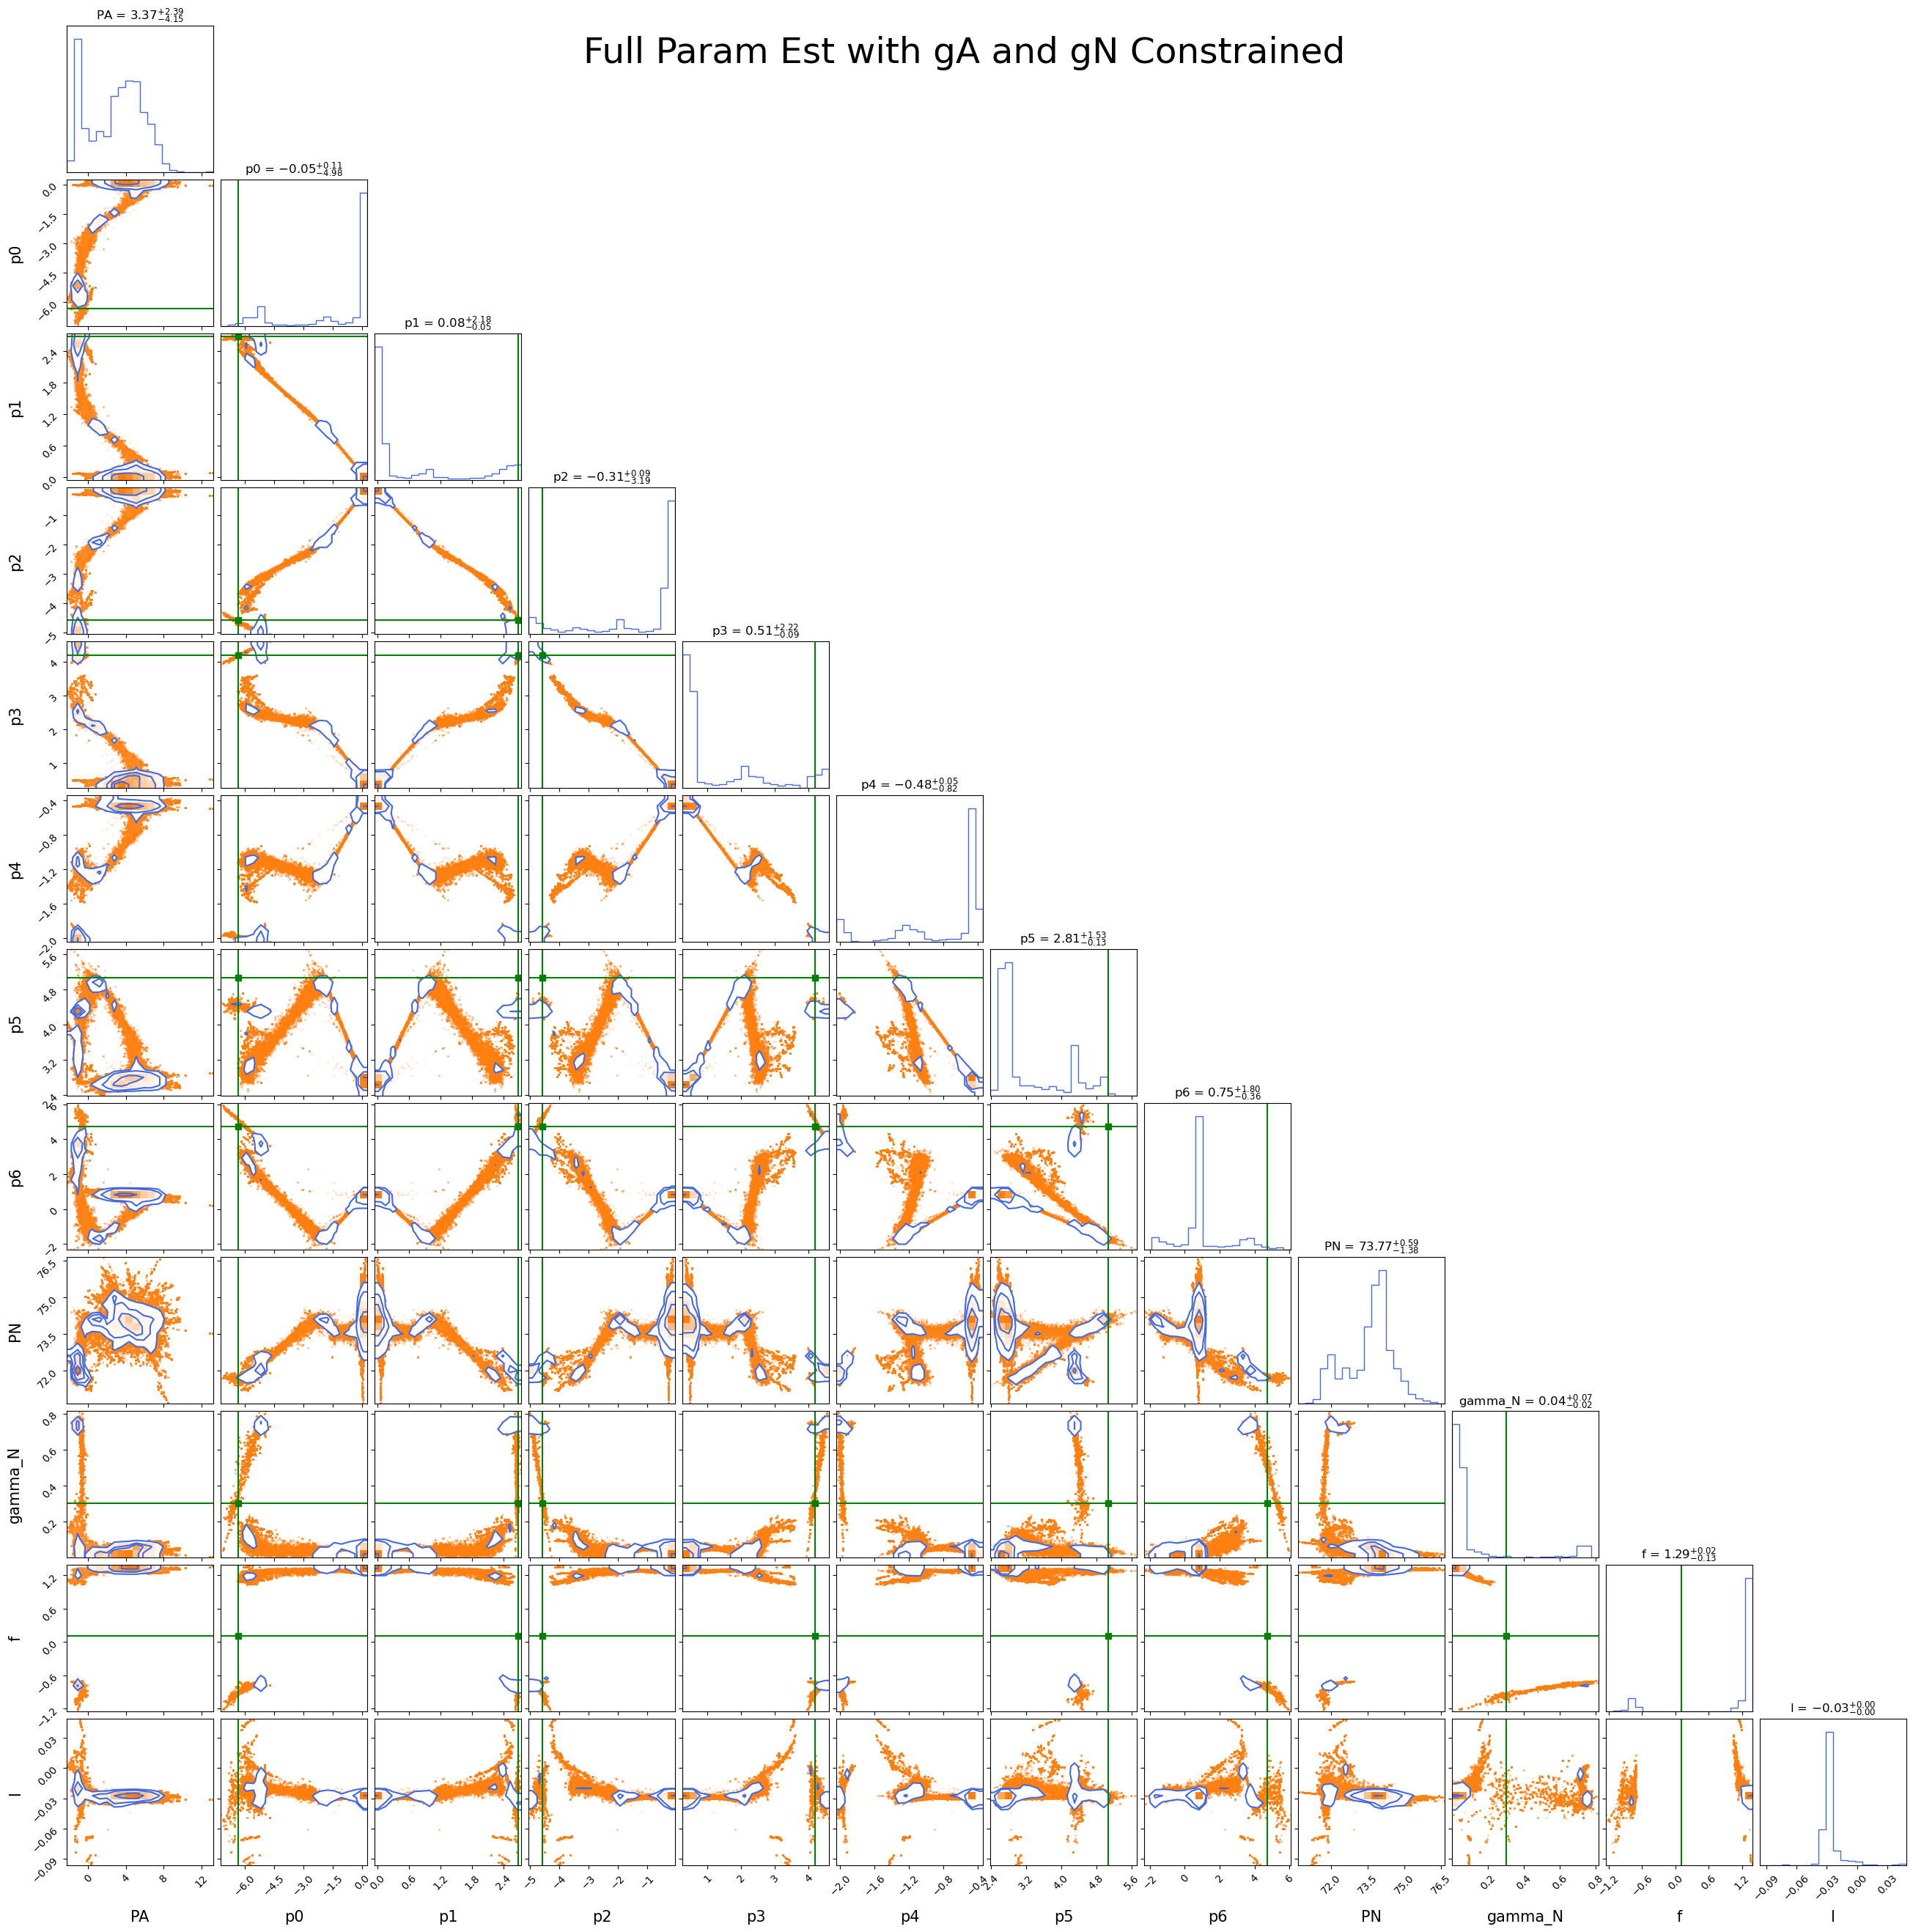

Best-fit parameters (Maximum Likelihood Estimate): [4.559855890142327, 0.05034124240984576, 0.038400869869896534, -0.22490714406544915, 0.42788605183716893, -0.4325692195155567, 2.6751096382471427, 0.7126341510074793, 74.60230955903579, 0.010852592087735799, 1.3350184428061111, -0.028424532871235364]


In [17]:
parameter_names = ["PA", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "PN", "gamma_N", "f", "l"]
ip_params=[300, -6.33, 2.67, -4.56, 4.18, -2.19, 5.07, 4.73, 70, 0.3, 0.1, 0.15]
#corner plot 
fig = corner.corner(samples_full, labels=parameter_names, show_titles=True, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
label_kwargs={"fontsize":15}, #set label size
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.suptitle("Full Param Est with gA and gN Constrained", fontsize=35)
#plt.savefig('/home/saurabhs/Documents/gopi/Saras_Model/RLC_Full_gA_1m_.png', dpi=300)
#plt.savefig('Art.png')

plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params_full)

[4.559855890142327, 0.05034124240984576, 0.038400869869896534, -0.22490714406544915, 0.42788605183716893, -0.4325692195155567, 2.6751096382471427, 0.7126341510074793, 74.60230955903579, 0.010852592087735799, 1.3350184428061111, -0.028424532871235364]


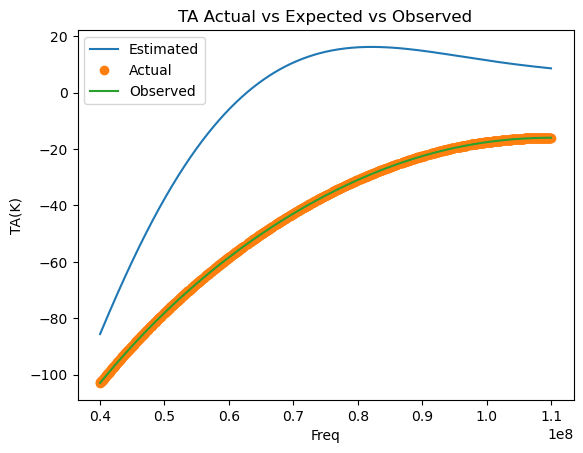

In [21]:
print(best_fit_params_full)
PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l =best_fit_params_full
TObs=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
#print(TMeas_exp.real[ind_freq].shape())
TMeas=TMeas_exp_avg.real

TEst=Compute_Tmeas_RLC(300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07, 4.73, 70, 0.3, 0.1, 0.15)
plt.plot(req_freq, TEst,label='Estimated')
plt.plot(req_freq,TMeas,'o', label='Actual' )
plt.plot(req_freq,TObs, label='Observed')
plt.legend()
plt.xlabel('Freq')
plt.ylabel('TA(K)')
plt.title('TA Actual vs Expected vs Observed')
plt.show()

Text(0, 0.5, 'S11')

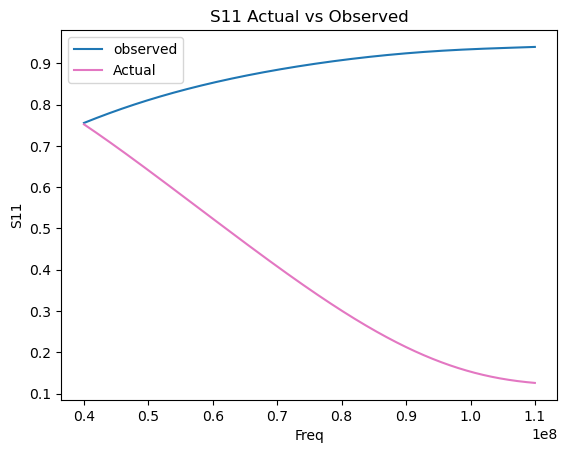

In [32]:
#Reconstructed S11 wrt best fit
v=req_freq
PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l =best_fit_params_full
gamma_A=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)

p0, p1, p2, p3, p4, p5, p6=[-6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73]
gA_True=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)

yerr=abs(gA_True-gamma_A)
#plt.errorbar(v, gamma_A, yerr, fmt=".C9", capsize=0, label="Error")
plt.plot(v,gamma_A,label='observed')
#plt.plot(v,gamma_rlc, label='Obeserved')
plt.plot(v,gA_True,'tab:pink', label='Actual')
plt.title("S11 Actual vs Observed")
plt.legend()
plt.xlabel('Freq')
plt.ylabel('S11')

In [33]:
#computing S11 corresponding to all samples
reduced_samples_rlc = samples_full
S11_models_rlc = np.zeros((len(reduced_samples_rlc), len(v)))

for ii in range(len(reduced_samples_rlc)):
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples_rlc[ii]
    S11_models_rlc[ii]=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)

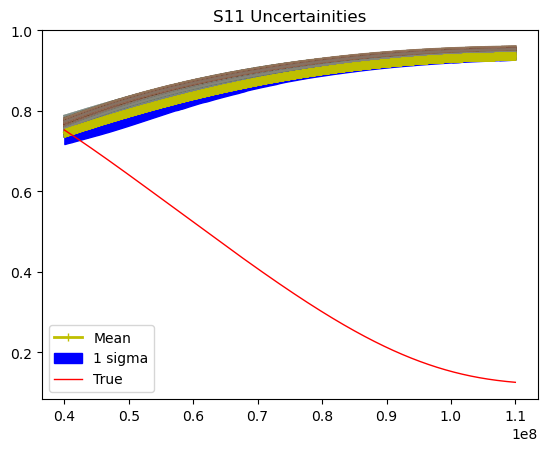

In [34]:
#plotting the correct S11 with mean S11, 1 sigma region and true value
plt.figure()
plt.plot(v, S11_models_rlc[0::100].T, alpha=0.1)

S11_mean_rlc = np.mean(S11_models_rlc, axis=0)
lower_bound, upper_bound = np.percentile(S11_models_rlc,[16,84],axis=0)

plt.plot(v, S11_mean_rlc, lw=2, color='y', marker='|', label="Mean")
plt.fill_between(v, lower_bound, upper_bound, color='b', zorder=-1, label="1 sigma")

p0, p1, p2, p3, p4, p5, p6=[-6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73]

gA_True=np.polyval([p0*1e-48, p1*1e-39, p2*1e-31, p3*1e-23, p4*1e-15, p5*1e-08, p6*1e-01],v)
plt.plot(v,gA_True, color='r', lw=1.0, label="True")
plt.title("S11 Uncertainities")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Uncertainities Exp vs Obs TA')

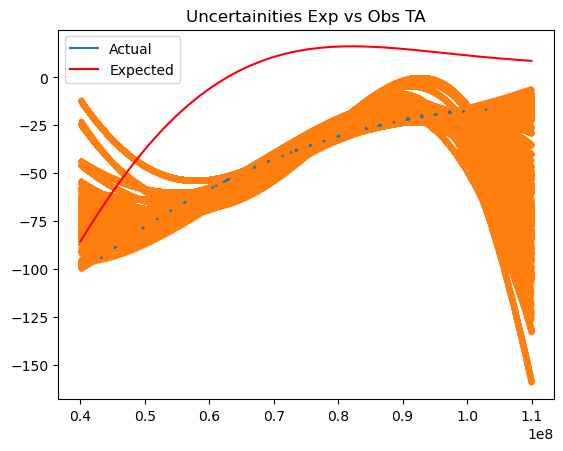

In [38]:
#Recovering Uncertainities in Tmeas
for ii in range(len(reduced_samples_rlc[::100])):
    PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l= reduced_samples_rlc[ii]
    #PA_o, gamma_Ao, PN, gamma_N, f, l=best_fit_params_o#[0,1,70, 0.3, 0.1, 0.15]
    TA_obs=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gamma_N, f, l)
    plt.plot(v, TA_obs,color='C1', marker=".", alpha=0.1, lw=1)
PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l=[300, -6.33,  2.67, -4.56,  4.17, -2.186,  5.07,  4.73, 70, 0.3, 0.1, 0.15]
TA_exp=Compute_Tmeas_RLC(PA, p0, p1, p2, p3, p4, p5, p6, PN, gN, f, l)
TMeas=TMeas_exp_avg.real[ind_freq]
plt.plot(req_freq,TMeas, label='Actual' )
plt.plot(v,TA_exp, 'r', label="Expected")
plt.legend()
plt.title("Uncertainities Exp vs Obs TA")